<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# @title data
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 64 # 4
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # get some random training images
images, labels = dataiter.next()
# imshow(torchvision.utils.make_grid(images))


Files already downloaded and verified
Files already downloaded and verified


In [34]:
# @title simplifi
# https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.i_downsample = i_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = nn.ReLU()(x)
        return x


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels*self.expansion),
        )
        self.i_downsample = i_downsample
        
    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None: #downsample if needed
            identity = self.i_downsample(identity)
        x += identity #add identity
        x = nn.ReLU()(x)
        return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        # https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
        # num_blocks=[3,3,3] aka layer_list
        # plane_list=[64,128,256]
        plane_list=[16,32,64] #og
        self.in_channels = plane_list[0]
        self.conv = nn.Sequential(
            nn.Conv2d(3, plane_list[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(plane_list[0]), nn.ReLU(),
            self._make_layer(ResBlock, layer_list[0], plane_list[0], stride=1),
            self._make_layer(ResBlock, layer_list[1], plane_list[1], stride=2),
            self._make_layer(ResBlock, layer_list[2], plane_list[2], stride=2),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        # self.fc = nn.Linear(plane_list[2]*ResBlock.expansion, num_classes)
        self.cc = nn.Conv2d(plane_list[2]*ResBlock.expansion, num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.reshape(x.shape[0], -1)
        # x = self.fc(x)
        x = self.cc(x)
        x = torch.squeeze(x)
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet(Bottleneck, [3,4,6,3], num_classes=10, num_channels=3).to(device)
model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
# print(model)

loss_list=[]


In [ ]:
# @title model

# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         plane_list=[64,128,256,512]
#         self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
#             nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(),# nn.MaxPool2d(2, 2),
#             nn.Conv2d(plane_list[0], plane_list[1], 5, 1, 2), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(plane_list[1], plane_list[2], 7, 1, 3), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
#         )
#         self.linear = nn.Sequential(
#             # nn.Linear(16 * 8 * 8, 256), nn.ReLU(),
#             nn.Linear(plane_list[2] * 8 * 8, 256), nn.ReLU(),
#             # nn.Linear(plane_list[2]//16, 256), nn.ReLU(),
#             nn.Linear(256, 64), nn.ReLU(),
#             nn.Linear(64, 10),
#         )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        plane_list=[64,128,256,512]
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(), #nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[0], plane_list[1], 3, 1, 1), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[2], 3, 1, 1), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(plane_list[2],64, 1, 1, 0), #nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 10, 1, 1, 0),
        )

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.view(-1, 16 * 5 * 5)
        # x = nn.Flatten()(x)
        # x = self.linear(x)
        x = torch.squeeze(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet().to(device)
# print(model)

loss_list=[]



In [ ]:
X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")


forward x torch.Size([64, 256, 8, 8])
torch.Size([64, 10, 8, 8])


In [37]:
# @title train test function

scaler = torch.cuda.amp.GradScaler()
# for data, label in data_iter:
#    optimizer.zero_grad()
#    # Casts operations to mixed precision
#    with torch.cuda.amp.autocast():
#       loss = model(data)
#    scaler.scale(loss).backward()
#    scaler.step(optimizer)
#    scaler.update()

# def strain(dataloader, model, loss_fn, optimizer):
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    lr_list, loss_list = [], []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            pred = model(sx)
            loss = loss_fn(pred, sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            lr_list.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
            loss_list.append(loss.item())

        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return lr_list, loss_list

# def train(dataloader, model, loss_fn, optimizer):
def train(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
    # for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # print("sx sy",sx.shape,sy.shape)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        # loss = model.loss(sx,sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if scheduler is not None: scheduler.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test(dataloader, model, loss_fn):
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct


In [ ]:
# @title lrfinder

# https://towardsdatascience.com/super-convergence-with-just-pytorch-c223c0fc1e51
# https://github.com/davidtvs/pytorch-lr-finder
# # https://arxiv.org/pdf/1506.01186.pdf
# LR range test
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall
# _/\

# cyclic
# 0.0001-0.001

# num_iter=20
# start_lr=3e-5
# end_lr= 3e-0
loss_fn = nn.CrossEntropyLoss()
#     model1=copy.deepcopy(model)
#     # for g in optimizer.param_groups: g['lr'] = start_lr
# https://stackoverflow.com/a/55760170
#         lr=optimizer.param_groups[0]["lr"]
#         # lr=scheduler.get_last_lr()[0]

def lrfinder(model1, dataloader, start_lr=1e-5, end_lr=1e1, num_iter=200):
    scaler = torch.cuda.amp.GradScaler()
    acc_list, lr_list, loss_list = [], [], []
    optimizer = torch.optim.AdamW(model1.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6) #3e-6
    # optimizer = torch.optim.SGD(model1.parameters(), lr=start_lr, momentum=0.9)
    gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    size = len(dataloader.dataset)
    model.train()
    loader_iter = iter(dataloader)
    for t in range(num_iter):
    # for batch, (x, y) in enumerate(dataloader):
        # if 
            # loader_iter = iter(dataloader)
        x, y = next(loader_iter)
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(sx)
            loss = loss_fn(pred, sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss.backward()
        # optimizer.step()

        lr=optimizer.param_groups[0]["lr"] # lr=scheduler.get_last_lr()[0]
        lr_list.append(lr); loss_list.append(loss.item())#; acc_list.append(accuracy)
        print("###### iter: ",t,", lr: ",lr,", loss: ",loss.item()) # print("accuracy: ",accuracy)
        scheduler.step()
    return lr_list, loss_list #,acc_list
    # # base_lr ,max_lr


batch_size=512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)

import time
start = time.time()

lr_list, loss_list = lrfinder(model, train_loader, start_lr=1e-8, end_lr=1e0, num_iter=97) #195(256) 97(512)

end = time.time()
print("time: ",end - start)


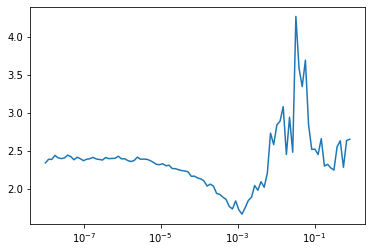

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(lr_list,acc_list)
# plt.plot(acc_list)
plt.plot(lr_list, loss_list)
# plt.plot(lr_list[:-40], loss_list[:-40])
plt.xscale('log')
plt.show()
plt.close()


In [ ]:
#  time epoch
import time
start = time.time()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
strain(train_loader, model, loss_fn, optimizer, verbose=False)

end = time.time()
print("time: ",end - start)


10
dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable', 'initial_lr', 'max_lr', 'min_lr', 'max_momentum', 'base_momentum'])
{'lr': 0.03, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 3e-06, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False}
[0.9498726057305127, 0.9494910720940466, 0.948857343298558, 0.9479746486807248, 0.946847486249988, 0.9454815997677258, 0.9438839494783627, 0.942062676641559, 0.940027062046218, 0.9377874787177128, 0.9353553390593273, 0.9327430366972642, 0.9299638833255673, 0.9270320408727799, 0.9239624493360028, 0.9207707506500943, 0.9174732089799549, 0.9140866278420714, 0.9106282644776488, 0.9071157419136642, 0.9035669591599615, 0.8999999999999999, 0.8964330408400384, 0.8928842580863358, 0.8893717355223512, 0.8859133721579284, 0.882526791020045, 0.8792292493499057, 0.8760375506639971, 0.8729679591272201, 0.8700361166744326, 0.8672569633027357, 0.8646446609406726, 0.8622125212822871

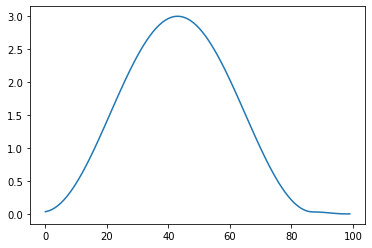

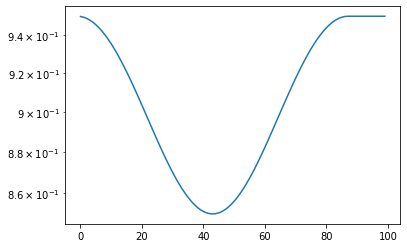

In [97]:
# @title plot lr
# https://efficientdl.com/faster-deep-learning-in-pytorch-a-guide
# https://pytorch.org/docs/stable/optim.html

# num_batches=int(np.ceil(len(train_dataset)/batch_size))
num_batches=10
print(num_batches)
epochs = 10 #5 20
# num_iter= epochs*num_batches #20
num_iter= 100

base_lr ,max_lr = 3e-2, 3e-0
end_lr,start_lr = 2,5

# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-4/1e-1)/(num_batches*epochs))
gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
# print("gamma",gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

# initial_lr = max_lr/div_factor
div_factor = max_lr/base_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)


# optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=base_lr)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=10, step_size_down=5, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=base_lr)
# torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(optimizer.param_groups[0].keys())
print(optimizer.defaults)
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR

# sgd
# dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach'])
# {'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None}
# +onecycle
# dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach', 'initial_lr', 'max_lr', 'min_lr', 'max_momentum', 'base_momentum'])
# {'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None}
# adamw
# dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable'])
# {'lr': 3e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 3e-06, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False}
# +onecycle
# dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable', 'initial_lr', 'max_lr', 'min_lr', 'max_momentum', 'base_momentum'])
# {'lr': 3e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 3e-06, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False}

# class schedulerbase():
#     def __init__(self, optimizer):
#         self.optimizer = optimizer
#     def step(self):
#         self.optimizer.param_groups[0]["lr"]+=1
#         self.optimizer.param_groups[0]["momentum"]-=0.1
# scheduler=schedulerbase(optimizer)



# epochs=epochs, steps_per_epoch=num_batches
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)

lr_list=[]
mm_list=[]
# for x in range(total_steps):
for x in range(num_iter):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    # mm=optimizer.param_groups[0]["momentum"]
    mm=optimizer.param_groups[0]["betas"][0]
    mm_list.append(mm)

print(mm_list)

import matplotlib.pyplot as plt
plt.plot(lr_list)
# plt.yscale('log')
plt.show()
plt.plot(mm_list)
plt.yscale('log')
plt.show()



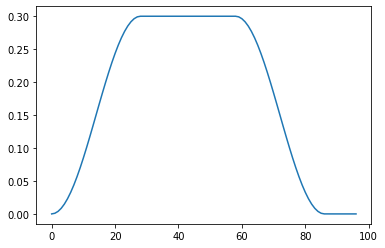

In [87]:




import torch
import numpy as np

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)


total_steps=97
step_ckpt=[0., 0.3, 0.6, 0.9, 1.]; lr_ckpt=[3e-5, 3e-1, 3e-1, 3e-5, 1e-9]; mm_ckpt=[0.95, 0.85, 0.85, 0.95, 0.95]


class schedulerme():
    def __init__(self, optimizer, total_steps, step_ckpt, lr_ckpt, mm_ckpt,anneal):
        self.optimizer = optimizer
        self.total_steps = total_steps
        self.step_ckpt = step_ckpt
        self.lr_ckpt = lr_ckpt
        self.mm_ckpt = mm_ckpt
        self.lr_schedule=np.array([])
        self.mm_schedule=np.array([])
        for n in range(len(step_ckpt)-1):
            num = round(step_ckpt[n+1]*total_steps)-round(step_ckpt[n]*total_steps)
            if anneal[n]=='lin': lr_lin = np.linspace(lr_ckpt[n], lr_ckpt[n+1], num=num)#,dtype="float32")
            elif anneal[n]=='cos': lr_lin = self.cos_func(lr_ckpt[n], lr_ckpt[n+1], num)
            elif anneal[n]=='exp': lr_lin = self.exp_func(lr_ckpt[n], lr_ckpt[n+1], num)
            mm_lin = np.linspace(mm_ckpt[n], mm_ckpt[n+1], num=num)#,dtype="float32")
            # mm_lin = self.cos_func(mm_ckpt[n], mm_ckpt[n+1], num)
            self.lr_schedule = np.append(self.lr_schedule,lr_lin)
            self.mm_schedule = np.append(self.mm_schedule,mm_lin)
        self.step_count = 0

    def step(self, n=None):
        # print(self.lr_schedule[self.step_count])
        self.optimizer.param_groups[0]["lr"]=self.lr_schedule[self.step_count]
        self.optimizer.param_groups[0]["betas"]=self.lr_schedule[self.step_count]
        
        # group['betas'] = (computed_momentum, *group['betas'][1:])
        # group['betas'] = (m_momentum, *group['betas'][1:])
        self.optimizer.param_groups[0]["momentum"]=self.mm_schedule[self.step_count]
        self.step_count+=1
    def cos_func(self, start, end, num):
        cos_out = np.cos(np.linspace(0., np.pi, num=num)) + 1
        return end + (start - end) / 2.0 * cos_out
    def exp_func(self, start, end, num):
        lin = np.linspace(0., 1., num=num)
        # start + lin*(end-start)
        # exp(ln(start) + lin*(ln(end)-ln(start)))
        # out = np.exp(np.log(start) + lin*(np.log(end)-np.log(start)))
        out = np.exp(np.log(start) + lin*(np.log(end/start)))
        return out


scheduler=schedulerme(optimizer,total_steps, 
                      step_ckpt=[0., 0.3, 0.6, 0.9, 1.], 
                      lr_ckpt=[3e-5, 3e-1, 3e-1, 3e-5, 1e-9], 
                      mm_ckpt=[0.95, 0.85, 0.85, 0.95, 0.95],
                      anneal=['cos','lin','cos','exp'])

lr_list=[]
mm_list=[]
for x in range(total_steps):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    mm=optimizer.param_groups[0]["momentum"]
    mm_list.append(mm)

import matplotlib.pyplot as plt
plt.plot(lr_list)
# plt.yscale('log')
plt.show()
# plt.plot(mm_list)
# # plt.yscale('log')
# plt.show()



In [40]:
# @title wwwwwwwww
import time
start = time.time()
lr_lst, loss_lst=[],[]
loss_fn = nn.CrossEntropyLoss()

# model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
batch_size = 512 # 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
base_lr, max_lr = 1e-5, 1e-3 #0.5#
end_lr, start_lr = 0.0001,0.1

num_batches=int(np.ceil(len(train_dataset)/batch_size))
# print(num_batches)
epochs = 10 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)

div_factor = max_lr/base_lr
# div_factor = 25
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    # lr_lst.append(lr)
    print(lr)
    # train(train_loader, model, loss_fn, optimizer)
    lr_ls, loss_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # strain(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
    # scheduler.step()
    lr_lst.append(lr_ls); loss_lst.append(loss_ls)
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))


Epoch 1
-------------------------------
1.0000000000000026e-05
loss: 0.283107  [    0/50000]
loss: 0.292462  [ 4608/50000]
loss: 0.298526  [ 9216/50000]
loss: 0.256354  [13824/50000]
loss: 0.316008  [18432/50000]
loss: 0.288968  [23040/50000]
loss: 0.284134  [27648/50000]
loss: 0.283023  [32256/50000]
loss: 0.354031  [36864/50000]
loss: 0.272778  [41472/50000]
loss: 0.289352  [46080/50000]
Accuracy: 83.0%, Avg loss: 0.521747
Epoch 2
-------------------------------
0.00012631332196008757
loss: 0.327772  [    0/50000]
loss: 0.271058  [ 4608/50000]
loss: 0.267451  [ 9216/50000]
loss: 0.315579  [13824/50000]
loss: 0.330843  [18432/50000]
loss: 0.308270  [23040/50000]
loss: 0.307701  [27648/50000]
loss: 0.304759  [32256/50000]
loss: 0.279227  [36864/50000]
loss: 0.246529  [41472/50000]
loss: 0.301479  [46080/50000]
Accuracy: 83.0%, Avg loss: 0.521406
Epoch 3
-------------------------------
0.0004205915146468512
loss: 0.238132  [    0/50000]
loss: 0.328372  [ 4608/50000]
loss: 0.298091  [ 92

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_lst)
# plt.yscale('log')
plt.show()
# plt.plot(lr_lst)
plt.show()

# print(len(lr_lst[0]))
# print(len(loss_lst[0])) 10,98


98
